<a href="https://colab.research.google.com/github/Anuskaghosh/Anuskaghosh/blob/main/Chest_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:25<00:00, 172MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.8MB/s]


In [ ]:
import zipfile

file_path = '/content/chest-xray-pneumonia.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "/content/drive/MyDrive/kaggle/chest_xray/train"
val_dir = "/content/drive/MyDrive/kaggle/chest_xray/val"
test_dir = "/content/drive/MyDrive/kaggle/chest_xray/test"

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling='avg')

for layer in base_model.layers[-5:]:
    layer.trainable = True

x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,532,481 (13.48 MB)

 Trainable params: 3,510,593 (13.39 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
opt  = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobileNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [ ]:
steps_per_epoch = train_gen.n // train_gen.batch_size
validation_steps = val_gen.n // val_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8629 - loss: 0.3205
Epoch 1: val_loss improved from inf to 0.33151, saving model to mobileNet_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 1155s 9s/step - accuracy: 0.8633 - loss: 0.3198 - val_accuracy: 0.8859 - val_loss: 0.3315
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 14:36 7s/step - accuracy: 1.0000 - loss: 0.1114

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.33151 to 0.32576, saving model to mobileNet_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 639ms/step - accuracy: 1.0000 - loss: 0.1114 - val_accuracy: 0.8869 - val_loss: 0.3258
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9388 - loss: 0.1635
Epoch 3: val_loss improved from 0.32576 to 0.21599, saving model to mobileNet_model.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 1141s 9s/step - accuracy: 0.9388 - loss: 0.1635 - val_accuracy: 0.9166 - val_loss: 0.2160
Epoch 4/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 14:07 7s/step - accuracy: 0.9375 - loss: 0.2304
Epoch 4: val_loss did not improve from 0.21599
130/130 ━━━━━━━━━━━━━━━━━━━━ 79s 563ms/step - accuracy: 0.9375 - loss: 0.2304 - val_accuracy: 0.9032 - val_loss: 0.2640
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9514 - loss: 0.1504
Epoch 5: val_loss did not improve from 0.21599
130/130 ━━━━━━━━━━━━━━━━━━━━ 1153s 9s/step - accuracy: 0.9515 - loss: 0.1503 - val_accuracy: 0.8178 - val_lo

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('mobileNet_model.keras')

test_loss, test_acc = model.evaluate(test_gen)
print('Test accuracy:', test_acc)
print('Test loss: ', test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9274 - loss: 0.3126
Test accuracy: 0.9262820482254028
Test loss:  0.3146323561668396


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the entire validation dataset
y_pred = model1.predict(val_gen)

# Flatten predictions to a 1D array
y_pred = np.round(y_pred).flatten()

# Collect true labels from the validation generator
y_true = val_gen.classes

# Print shapes to ensure they match
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_true: {len(y_true)}")

# Ensure y_true matches y_pred in size
if len(y_pred) == len(y_true):
    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
else:
    print("Mismatch in number of samples between predictions and true labels.")


33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
Shape of y_pred: (1043,)
Shape of y_true: 1043
Classification Report:
              precision    recall  f1-score   support

      Normal       0.25      0.22      0.23       268
   Pneumonia       0.74      0.77      0.76       775

    accuracy                           0.63      1043
   macro avg       0.50      0.50      0.50      1043
weighted avg       0.62      0.63      0.62      1043

Confusion Matrix:
[[ 59 209]
 [176 599]]


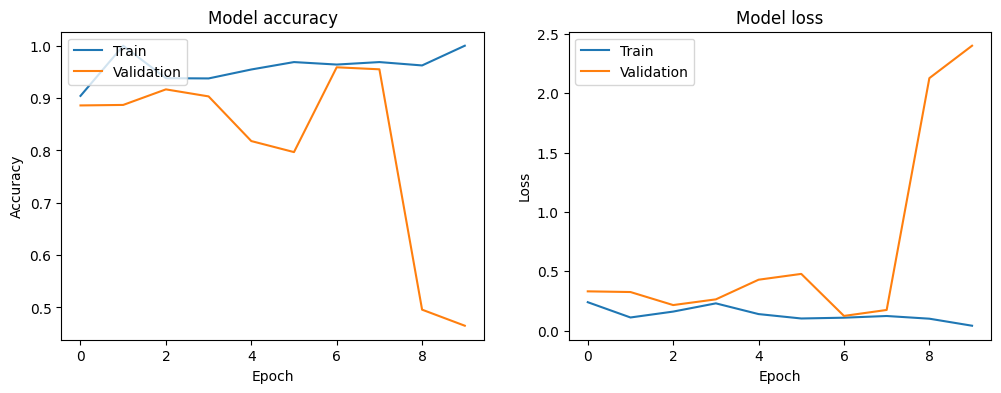

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


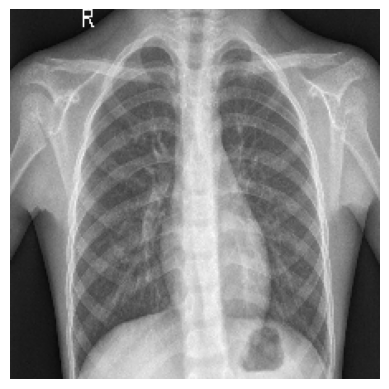

Predicted labels: [[0.00098762]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

model1 = load_model("/content/mobileNet_model.keras")

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to match the model's training
    return img_array, img

# Specify the path to your image
img_path = '/content/drive/MyDrive/kaggle/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
target_size = (224, 224)  # Set this to the input shape of your model

# Load and preprocess the image
img_array, img = load_and_preprocess_image(img_path, target_size)

# Make the prediction
prediction = model1.predict(img_array)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the predicted label(s)
print(f"Predicted labels: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


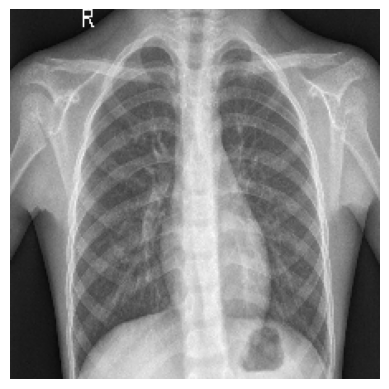

Predicted label: Normal (Confidence: 0.00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to match the model's training
    return img_array, img

# Specify the path to your image
img_path = '/content/drive/MyDrive/kaggle/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
target_size = (224, 224)
# Load and preprocess the image
img_array, img = load_and_preprocess_image(img_path, target_size)

# Make the prediction
prediction = model1.predict(img_array)[0][0]  # Extract the prediction

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Determine the label based on the prediction
label = 'Normal' if prediction < 0.5 else 'Pneumonia'

# Print the predicted label
print(f"Predicted label: {label} (Confidence: {prediction:.2f})")
